# Sistem Rekomendasi Destinasi Wisata Berbasis Collaborative Filtering
<hr>


In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!rm -rf data

In [3]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
! kaggle datasets download -d aprabowo/indonesia-tourism-destination

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 38.6MB/s]


In [5]:
import zipfile
import os

In [6]:
local_zip = 'indonesia-tourism-destination.zip'
target_extraction = '/content/data/'
file_check = "dataset"

try:
    if os.path.exists(os.path.join(target_extraction, file_check)):
        print("File Already Extracted")
    else:
        zip_ref = zipfile.ZipFile(local_zip, 'r')
        zip_ref.extractall(target_extraction)

except FileNotFoundError:
    print('Zip File Not Found!')

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [8]:
pip install --upgrade TENSORFLOW

## 1. Mengimpor Library Python yang Dibutuhkan

In [9]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

In [10]:
# Upload semua dataset yang dipakai
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 3. Data Understanding

### 3.1 Menyiapkan Data

In [11]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('data/tourism_rating.csv')
place = pd.read_csv('data/tourism_with_id.csv')
user = pd.read_csv('data/user.csv')

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [12]:
# Melihat gambaran data place

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [13]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [14]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


In [15]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

In [16]:
df = pd.DataFrame(place)
print("Data sebelum diurutkan:")
print(df)


Data sebelum diurutkan:
     Place_Id                                 Place_Name  \
0           1                           Monumen Nasional   
1           2                                   Kota Tua   
2           3                              Dunia Fantasi   
3           4          Taman Mini Indonesia Indah (TMII)   
4           5                   Atlantis Water Adventure   
..        ...                                        ...   
432       433                        Museum Mpu Tantular   
433       434                              Taman Bungkul   
434       435           Taman Air Mancur Menari Kenjeran   
435       436               Taman Flora Bratang Surabaya   
436       437  Gereja Perawan Maria Tak Berdosa Surabaya   

                                           Description       Category  \
0    Monumen Nasional atau yang populer disingkat d...         Budaya   
1    Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya   
2    Dunia Fantasi atau disebut juga

In [17]:
#Memfilter data berdasarkan rentang ID 1-20
filter1 = df[(df['Place_Id'] >= 1) & (df['Place_Id'] <= 20)]

#Memfilter data berdasarkan rentang ID 85-105
filter2 = df[(df['Place_Id'] >= 85) & (df['Place_Id'] <= 105)]

#Memfilter data berdasarkan rentang ID 211-231
filter3 = df[(df['Place_Id'] >= 211) & (df['Place_Id'] <= 231)]

#Memfilter data berdasarkan rentang ID 335-355
filter4 = df[(df['Place_Id'] >= 335) & (df['Place_Id'] <= 355)]

#Memfilter data berdasarkan rentang ID 392-412
filter5 = df[(df['Place_Id'] >= 392) & (df['Place_Id'] <= 412)]

#Menggabungkan hasil filter
filtered_df = pd.concat([filter1, filter2, filter3, filter4, filter5])

#Mengurutkan dataset yang sudah difilter berdasarkan kolom 'ID'
place = filtered_df.sort_values(by='Place_Id')

df_user = pd.DataFrame(user)

In [18]:
# Menampilkan data setelah diurutkan
print("\nData setelah diurutkan:")
print(place)


Data setelah diurutkan:
     Place_Id                         Place_Name  \
0           1                   Monumen Nasional   
1           2                           Kota Tua   
2           3                      Dunia Fantasi   
3           4  Taman Mini Indonesia Indah (TMII)   
4           5           Atlantis Water Adventure   
..        ...                                ...   
407       408            Kebun Binatang Surabaya   
408       409                        Rumah Batik   
409       410                  Ciputra Waterpark   
410       411          Masjid Muhammad Cheng Hoo   
411       412           Masjid Nasional Al-Akbar   

                                           Description       Category  \
0    Monumen Nasional atau yang populer disingkat d...         Budaya   
1    Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya   
2    Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan   
3    Taman Mini Indonesia Indah merupakan suatu kaw...  Ta

## Data Category

#### 3.2.2. Data rating

In [19]:
def create_variation(df_user, n):
    dfs = [df_user.copy() for _ in range(n)]
    for i, df_var in enumerate(dfs):
        df_var['User_Id'] += i * len(df_user)  # Mengubah User_Id
    return pd.concat(dfs, ignore_index=True)

# Menduplikasi dan membuat variasi pada data user
df_varied_user = create_variation(user, 3)  # 3 adalah jumlah variasi


In [20]:
# melihat gambaran data rating

rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [21]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [22]:
# Merubah data rating agar hanya berisi rating pada tempat wisata
rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


In [23]:
rating.shape

(2368, 3)

#### 3.2.3. Data user

In [24]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [25]:
# Merubah data user agar hanya berisi user yang pernah megunjungi wisata

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').sort_values('User_Id')
user.head()

,User_Id,Location,Age
83,1,"Semarang, Jawa Tengah",20
415,1,"Semarang, Jawa Tengah",20
1930,1,"Semarang, Jawa Tengah",20
825,1,"Semarang, Jawa Tengah",20
1637,1,"Semarang, Jawa Tengah",20


In [26]:
# Melihat dataset user yang pernah memberi rating pada wisata

user.shape

(2368, 3)

## 4. Eksplorasi Data

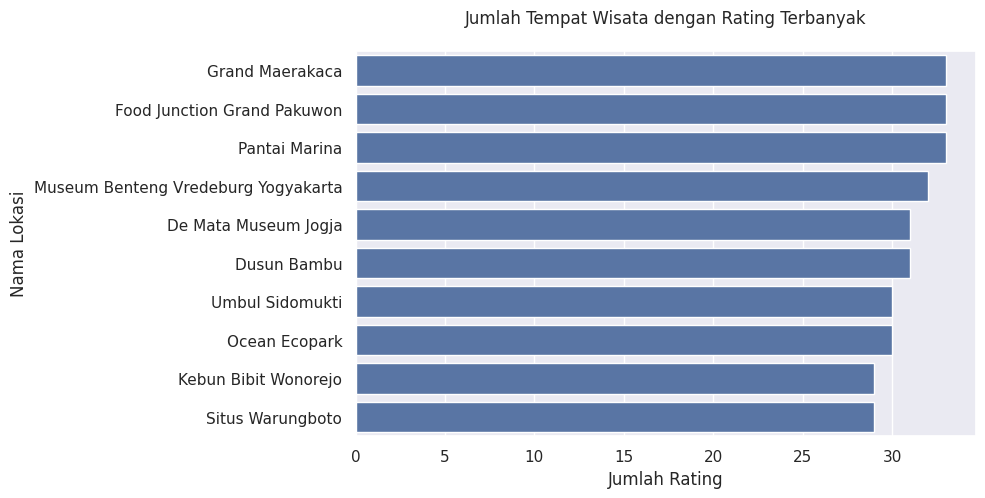

In [27]:
# Membuat dataframe berisi lokasi dengan jumlah rating terbanyak
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10.columns = ['Place_Id', 'count']  # Rename columns for easier access
top_10 = pd.merge(top_10, place[['Place_Id', 'Place_Name']], how='left', on='Place_Id')


# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(8, 5))
sns.barplot(x='count', y='Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Nama Lokasi')
plt.xlabel('Jumlah Rating')
plt.show()

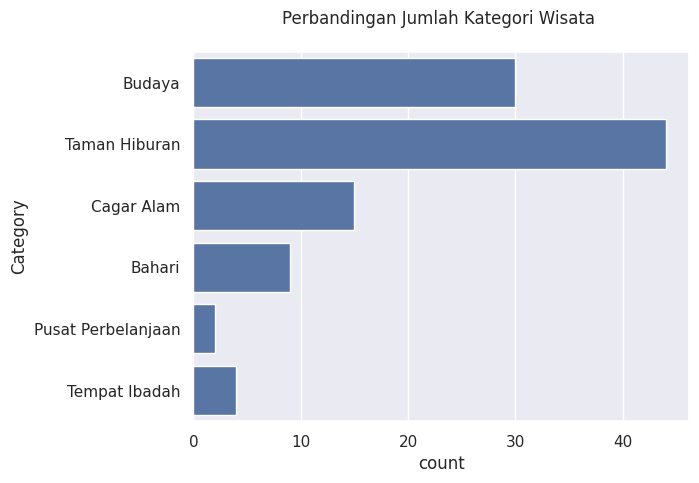

In [28]:
# Membuat visualisasi jumlah kategori wisata

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata ', pad=20)
plt.show()

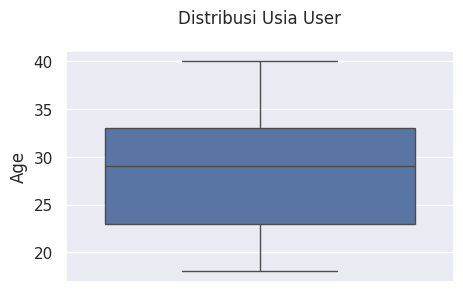

In [29]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

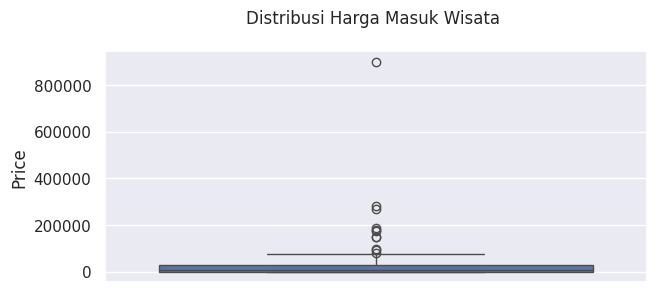

In [30]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata ', pad=20)
plt.show()

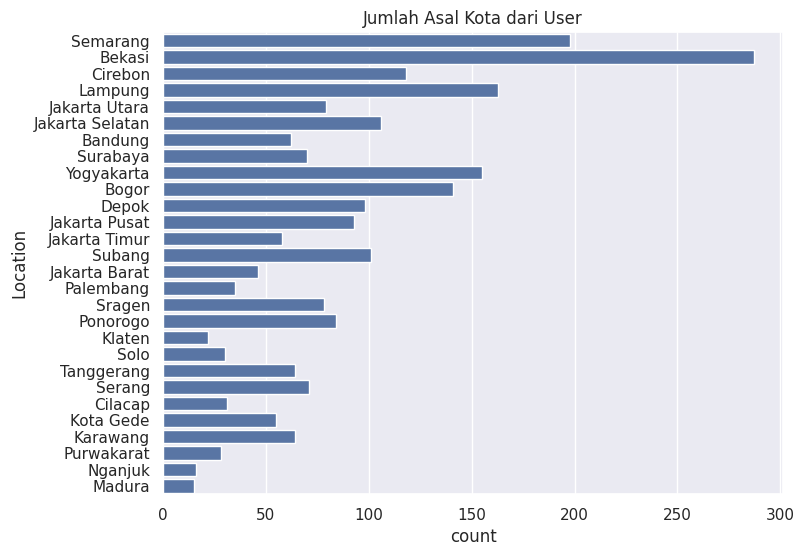

In [31]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## 5. Persiapan Data untuk Pemodelan

### 5.1. Membuat Salinan Data rating

In [32]:
# Membaca dataset untuk dilakukan encoding

df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


### 5.2. Melakukan Encoding

#### 5.2.1. Membuat Fungsi untuk Melakukan Encoding

In [33]:
def dict_encoder(col, data):
    unique_val = data[col].unique().tolist()
    val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
    val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
    return val_to_val_encoded, val_encoded_to_val

def encode_data(df):
    user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id', df)
    df['user'] = df['User_Id'].map(user_to_user_encoded)

    place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id', df)
    df['place'] = df['Place_Id'].map(place_to_place_encoded)

    return df, user_to_user_encoded, place_to_place_encoded

# Menyandikan data rating
rating_encoded, user_to_user_encoded, place_to_place_encoded = encode_data(rating)

# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)

# Mengubah rating menjadi nilai float
rating_encoded['Place_Ratings'] = rating_encoded['Place_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(rating_encoded['Place_Ratings']), max(rating_encoded['Place_Ratings'])
print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 300, Number of Place: 104, Min Rating: 1.0, Max Rating: 5.0


#### 5.2.2. Encoding dan Mapping Kolom User

### 5.3. Melihat Gambaran Data untuk Pemodelan

In [34]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head(2)

,User_Id,Place_Id,Place_Ratings
1094,289,217,2
188,61,9,3


## 6. Pemodelan Machine Learning

### 6.1. Membagi data train dan test

In [35]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = rating_encoded[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
y = rating_encoded['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * rating_encoded.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)


### 6.2. Menyiapkan Model

#### Deklarasi Fungsi

In [36]:
def dict_encoder(col, data):
    unique_val = data[col].unique().tolist()
    val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
    val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
    return val_to_val_encoded, val_encoded_to_val


def encode_data(df):
    user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id', df)
    df['user'] = df['User_Id'].map(user_to_user_encoded)

    place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id', df)
    df['place'] = df['Place_Id'].map(place_to_place_encoded)

    return df, user_to_user_encoded, place_to_place_encoded


#### Membaca, Mengolah, dan Mempersiapkan Data:

In [37]:

# Membaca data dan melakukan encoding
df_encoded, user_to_user_encoded, place_to_place_encoded = encode_data(rating)

# Mendapatkan jumlah user dan place
num_users, num_places = len(user_to_user_encoded), len(place_to_place_encoded)

# Mengubah rating menjadi nilai float
df_encoded['Place_Ratings'] = df_encoded['Place_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df_encoded['Place_Ratings']), max(df_encoded['Place_Ratings'])

In [38]:
# Assuming `place` and `df` are your dataframes

# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id', place)

# Mapping Place_Id to dataframe df
df['place'] = df['Place_Id'].map(place_to_place_encoded)

# Print df to verify the encoding
print(df)


      User_Id  Place_Id  Place_Ratings  place
1094      289       217              2     47
188        61         9              3      8
1800      238       350              3     77
707       239        95              5     30
679       255        94              2     29
...       ...       ...            ...    ...
1638       10       344              3     71
1095      297       217              4     47
1130       69       219              2     49
1294       91       226              3     56
860       123       102              1     37

[2368 rows x 4 columns]


#### Pembagian Data dan Persiapan untuk Pelatihan:

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import GaussianNoise, Dropout, BatchNormalization, Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [40]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, GaussianNoise, Flatten, Concatenate, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.losses import MeanSquaredError

def create_ncf_model(num_users, num_places, embedding_size=50):
    user_input = Input(shape=(1,), name='user_input')
    place_input = Input(shape=(1,), name='place_input')

    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    user_embedding = GaussianNoise(0.1)(user_embedding)

    place_embedding = Embedding(input_dim=num_places, output_dim=embedding_size, name='place_embedding')(place_input)
    place_embedding = GaussianNoise(0.1)(place_embedding)

    user_flatten = Flatten()(user_embedding)
    place_flatten = Flatten()(place_embedding)

    concat = Concatenate()([user_flatten, place_flatten])

    dense = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3))(concat)
    batch_norm = BatchNormalization()(dense)
    dropout = Dropout(0.4)(batch_norm)

    dense_2 = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3))(dropout)
    batch_norm_2 = BatchNormalization()(dense_2)
    dropout_2 = Dropout(0.4)(batch_norm_2)

    dense_3 = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3))(dropout_2)
    batch_norm_3 = BatchNormalization()(dense_3)
    dropout_3 = Dropout(0.4)(batch_norm_3)

    output = Dense(1, activation='sigmoid')(dropout_3)

    model = Model(inputs=[user_input, place_input], outputs=output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-3), metrics=['mse'])

    return model

# Anda asumsikan num_users dan num_places sudah didefinisikan
# model = create_ncf_model(num_users, num_places)
# model.summary()

# Implementasi K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
fold_no = 1
mse_scores = []

best_models = []

for fold_no, (train, test) in enumerate(kfold.split(x, y), 1):
    model = create_ncf_model(num_users, num_place, embedding_size=50)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(
        filepath=f'best_model_fold_{fold_no}.keras',  # Ubah ekstensi ke .h5
        monitor='val_loss',
        save_best_only=True
    )

    history = model.fit(
        [x[train, 0], x[train, 1]], y[train],
        batch_size=128,
        epochs=100,
        validation_data=([x[test, 0], x[test, 1]], y[test]),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )

    # Muat model terbaik dari setiap fold
    best_model_fold = load_model(f'best_model_fold_{fold_no}.keras', custom_objects={'mse': 'mse'})  # Diperbaiki
    best_models.append(best_model_fold)

# Gabungkan semua model terbaik menjadi satu model
final_model = create_ncf_model(num_users, num_place, embedding_size=50)

# Set atribut trainable ke False untuk semua layer agar dibekukan
for layer in final_model.layers:
    layer.trainable = False

# Transfer bobot dari model-model terbaik
for fold_model in best_models:
    final_model.set_weights(fold_model.get_weights())

# Simpan model final dalam format Keras asli
final_model.save('best_model.keras')

# Muat kembali model, spesifikasikan 'mse' di custom_objects
final_model = load_model('best_model.keras', custom_objects={'mse': 'mse'})

Epoch 1/100
15/15 [==============================] - 17s 283ms/step - loss: 0.6462 - mse: 0.2076 - val_loss: 0.5540 - val_mse: 0.1201 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 2s 97ms/step - loss: 0.6231 - mse: 0.1931 - val_loss: 0.5467 - val_mse: 0.1213 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 1s 63ms/step - loss: 0.6191 - mse: 0.1976 - val_loss: 0.5402 - val_mse: 0.1232 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 1s 51ms/step - loss: 0.5982 - mse: 0.1851 - val_loss: 0.5335 - val_mse: 0.1249 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 1s 74ms/step - loss: 0.5829 - mse: 0.1781 - val_loss: 0.5265 - val_mse: 0.1261 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 1s 39ms/step - loss: 0.5708 - mse: 0.1742 - val_loss: 0.5190 - val_mse: 0.1268 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 0s 27ms/step - loss: 0.5536 - mse: 0.1652 - val_loss: 0.5108 - val_mse: 0.1

In [41]:
final_model.compile(loss='mse', optimizer=Adam(learning_rate=1e-3), metrics=['MeanSquaredError'])

In [42]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model

# Load the model, specifying the custom loss function
final_model = load_model('best_model.keras', custom_objects={'MeanSquaredError': MeanSquaredError})


In [43]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import os


# Memuat model dengan eksplisit menyertakan MeanSquaredError sebagai custom object
final_model = load_model('best_model.keras', custom_objects={'mse': MeanSquaredError()})

#### Inisialisasi dan Pelatihan Model:

#### Visualisasi Hasil Pelatihan

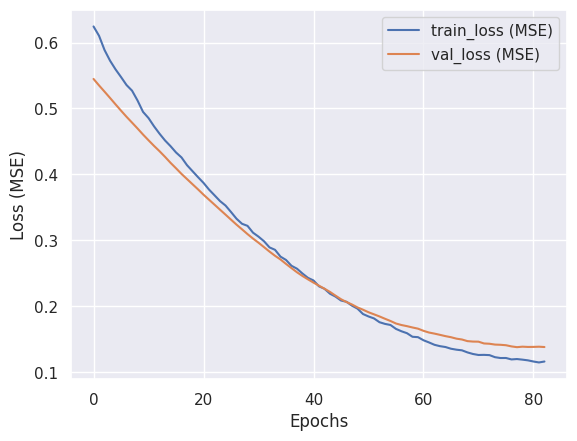

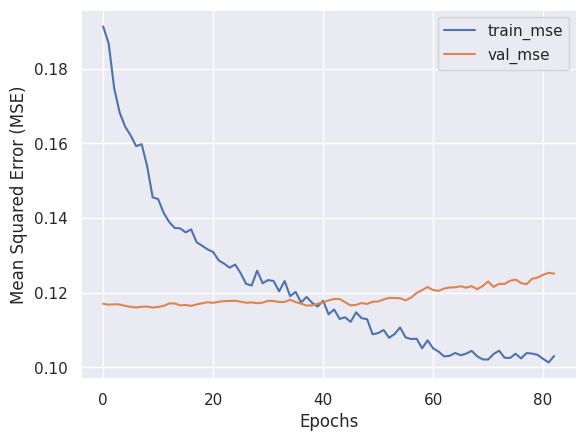

In [44]:
# Visualisasi hasil training dan validasi
plt.plot(history.history['loss'], label='train_loss (MSE)')
plt.plot(history.history['val_loss'], label='val_loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='train_mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

## hasil rekomendasi untuk user

In [46]:
import pandas as pd
import numpy as np

# Assume user_to_user_encoded and place_to_place_encoded are dictionaries
# Assume place DataFrame is available and contains information about places

# Read new user data
new_user = pd.read_csv('new_user_data_1.csv')

# Read new rating data
new_rating = pd.read_csv('new_rating_data.csv')

# Display the first few rows to verify
print(new_user.head())
print(new_rating.head())

# Assuming 'place' DataFrame is defined and contains information about places
new_rating_merged = pd.merge(new_rating, place, on='Place_Id', how='left')

# Display the first few rows of merged data to verify
print(new_rating_merged.head())

# Assuming 'user_to_user_encoded' and 'place_to_place_encoded' mappings are defined correctly

# Encode User_Id in new_user data
new_user_encoded = new_user.copy()
new_user_encoded['user'] = new_user_encoded['User_Id'].map(user_to_user_encoded)

# Encode User_Id and Place_Id in new_rating_merged data
new_rating_merged['user'] = new_rating_merged['User_Id'].map(user_to_user_encoded)
new_rating_merged['place'] = new_rating_merged['Place_Id'].map(place_to_place_encoded)

# Create all possible pairs of the new user and all places
user_id = 7 # Replace with the user ID you want to predict for
user_encoded = user_to_user_encoded[user_id]
all_places = np.array(list(place_to_place_encoded.values()))
all_user_place = np.array(np.meshgrid([user_encoded], all_places)).T.reshape(-1, 2)
df_all_user_place = pd.DataFrame(all_user_place, columns=['user', 'place'])

# Predict using the final_model
predictions = final_model.predict([df_all_user_place['user'], df_all_user_place['place']])

# Add predicted ratings to the DataFrame
df_all_user_place['predicted_rating'] = predictions.flatten()

# Decode the place IDs
df_all_user_place['Place_Id'] = df_all_user_place['place'].map({v: k for k, v in place_to_place_encoded.items()})

# Merge with place details
user_predictions = pd.merge(df_all_user_place, place, on='Place_Id', how='left')

# Filter only places with 'Budaya' category (or any category you want)
user_predictions = user_predictions[user_predictions['Category'] == 'Budaya']

# Sort predictions by predicted rating in descending order
user_predictions = user_predictions.sort_values(by='predicted_rating', ascending=False)

# Display top 10 recommendations for the user
print(f"Top 10 Recommendations for User ID {user_id}:")
for index, row in user_predictions.head(10).iterrows():
    place_id = row['Place_Id']
    place_name = row['Place_Name']
    category = row['Category']
    predicted_rating = row['predicted_rating']
    print(f"Place ID: {place_id}")
    print(f"Place Name: {place_name}")
    print(f"Category: {category}")
    print(f"Predicted Rating: {predicted_rating:.4f}")
    print("-" * 50)


   User_Id
0        2
1        7
2        6
3        8
4        3
   Place_Id  Place_Ratings  User_Id
0         9              3        2
1         1              4        2
2         9              4        7
3         5              4        7
4         7              5        6
   Place_Id  Place_Ratings  User_Id                Place_Name  \
0         9              3        2          Pelabuhan Marina   
1         1              4        2          Monumen Nasional   
2         9              4        7          Pelabuhan Marina   
3         5              4        7  Atlantis Water Adventure   
4         7              5        6    Kebun Binatang Ragunan   

                                         Description       Category     City  \
0  Pelabuhan Marina Ancol berada di kawasan Taman...         Bahari  Jakarta   
1  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
2  Pelabuhan Marina Ancol berada di kawasan Taman...         Bahari  Jakarta   
3  Atla

In [48]:
# Misalnya, jika Anda memuat data dari file CSV
import pandas as pd

# Ganti 'nama_file.csv' dengan nama file yang sesuai
df = pd.read_csv('place_data.csv')

# Cetak semua nama kolom untuk memeriksa apakah 'Category' ada di sana
print(df.columns)


Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Coordinate', 'Lat', 'Long'],
      dtype='object')


In [49]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Assuming user_to_user_encoded, place_to_place_encoded, and place DataFrame are defined
# Load the final trained model
final_model = load_model('best_model.keras', custom_objects={'mse': 'mse'})

# User ID to predict
user_id = 16
user_encoded = user_to_user_encoded[user_id]

# Get all place IDs and their encoded values
all_place_ids = np.array(list(place_to_place_encoded.keys()))
all_place_encoded = np.array(list(place_to_place_encoded.values()))

# Create user-place pairs for the given user
user_place_pairs = np.array([[user_encoded, place] for place in all_place_encoded])
df_user_place = pd.DataFrame(user_place_pairs, columns=['user', 'place'])

# Predict ratings using the trained model
predictions = final_model.predict([df_user_place['user'], df_user_place['place']])

# Add predicted ratings to DataFrame
df_user_place['predicted_rating'] = predictions.flatten()

# Merge with place DataFrame to get place details
df_user_place = df_user_place.merge(place, left_on='place', right_on='Place_Id')

# Filter only places with 'Budaya' category
df_user_place = df_user_place[df_user_place['Category'] == 'Budaya']

# Sort predictions by predicted rating in descending order
df_user_place = df_user_place.sort_values(by='predicted_rating', ascending=False)

# Display top 10 recommendations for the user
print(f"Top 10 Recommendations for User ID {user_id}:")
for index, row in df_user_place.head(10).iterrows():
    place_id = row['Place_Id']
    place_name = row['Place_Name']
    category = row['Category']
    predicted_rating = row['predicted_rating']
    print(f"Place ID: {place_id}")
    print(f"Place Name: {place_name}")
    print(f"Category: {category}")
    print(f"Predicted Rating: {predicted_rating:.4f}")
    print("-" * 50)


4/4 [==============================] - 0s 3ms/step
Top 10 Recommendations for User ID 16:
Place ID: 100
Place Name: Taman Budaya Yogyakarta
Category: Budaya
Predicted Rating: 0.5686
--------------------------------------------------
Place ID: 17
Place Name: Museum Fatahillah
Category: Budaya
Predicted Rating: 0.5547
--------------------------------------------------
Place ID: 86
Place Name: Keraton Yogyakarta
Category: Budaya
Predicted Rating: 0.5450
--------------------------------------------------
Place ID: 88
Place Name: Museum Benteng Vredeburg Yogyakarta
Category: Budaya
Predicted Rating: 0.5425
--------------------------------------------------
Place ID: 89
Place Name: De Mata Museum Jogja
Category: Budaya
Predicted Rating: 0.5419
--------------------------------------------------
Place ID: 16
Place Name: Jembatan Kota Intan
Category: Budaya
Predicted Rating: 0.5380
--------------------------------------------------
Place ID: 1
Place Name: Monumen Nasional
Category: Budaya
Predi

In [50]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Read new user data
new_user = pd.read_csv('new_user_data_1.csv')

# Read new rating data
new_rating = pd.read_csv('new_rating_data.csv')

# Read place data
place_data = pd.read_csv('place_data.csv')

# Display the first few rows to verify
print(new_user.head())
print(new_rating.head())
print(place_data.head())

# Merge new rating data with place data (if place_data contains relevant columns)
# Assuming 'place_to_place_encoded' mappings are defined correctly
new_rating_merged = pd.merge(new_rating, place_data[['Place_Id', 'Category']], on='Place_Id', how='left')

# Encode User_Id in new_user data
new_user_encoded = new_user.copy()
new_user_encoded['user'] = new_user_encoded['User_Id'].map(user_to_user_encoded)

# Encode User_Id and Place_Id in new_rating_merged data
new_rating_merged['user'] = new_rating_merged['User_Id'].map(user_to_user_encoded)
# Assuming place_to_place_encoded mappings are defined correctly
new_rating_merged['place'] = new_rating_merged['Place_Id'].map(place_to_place_encoded)

def get_recommendations_for_user(user_id, category='Budaya'):
    # Create all possible pairs of the new user and all places
    user_encoded = user_to_user_encoded[user_id]
    all_places = np.array(list(place_to_place_encoded.values()))
    all_user_place = np.array(np.meshgrid([user_encoded], all_places)).T.reshape(-1, 2)
    df_all_user_place = pd.DataFrame(all_user_place, columns=['user', 'place'])

    # Predict using the final_model
    predictions = final_model.predict([df_all_user_place['user'], df_all_user_place['place']])

    # Add predicted ratings to the DataFrame
    df_all_user_place['predicted_rating'] = predictions.flatten()

    # Decode the place IDs
    df_all_user_place['Place_Id'] = df_all_user_place['place'].map({v: k for k, v in place_to_place_encoded.items()})

    # Merge with place details from place_data (if needed for additional info)
    user_predictions = pd.merge(df_all_user_place, place_data, on='Place_Id', how='left')

    # Filter only places with the specified category (or any other criteria)
    user_predictions = user_predictions[user_predictions['Category'] == category]

    # Sort predictions by predicted rating in descending order
    user_predictions = user_predictions.sort_values(by='predicted_rating', ascending=False)

    return user_predictions

# Load the final model
final_model = load_model('best_model.keras', custom_objects={'mse': 'mse'})

# Example: Get recommendations for User ID 8 in 'Bahari' category
user_id = 8
user_predictions = get_recommendations_for_user(user_id, category='Bahari')

# Display top 10 recommendations for the user
print(f"Top 10 Recommendations for User ID {user_id} in 'Bahari' Category:")
for index, row in user_predictions.head(10).iterrows():
    place_id = row['Place_Id']
    place_name = row['Place_Name']
    category = row['Category']
    predicted_rating = row['predicted_rating']
    print(f"Place ID: {place_id}")
    print(f"Place Name: {place_name}")
    print(f"Category: {category}")
    print(f"Predicted Rating: {predicted_rating:.4f}")
    print("-" * 50)


   User_Id
0        2
1        7
2        6
3        8
4        3
   Place_Id  Place_Ratings  User_Id
0         9              3        2
1         1              4        2
2         9              4        7
3         5              4        7
4         7              5        6
   Place_Id                         Place_Name  \
0       1.0                   Monumen Nasional   
1       2.0                           Kota Tua   
2       3.0                      Dunia Fantasi   
3       4.0  Taman Mini Indonesia Indah (TMII)   
4       5.0           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water

In [51]:
import pandas as pd
import numpy as np

# Assuming user_to_user_encoded, place_to_place_encoded, model, and place are defined

# Dataframe that contains all possible user-place pairs
all_users = np.array(list(user_to_user_encoded.values()))
all_places = np.array(list(place_to_place_encoded.values()))
all_user_place = np.array(np.meshgrid(all_users, all_places)).T.reshape(-1, 2)
df_all_user_place = pd.DataFrame(all_user_place, columns=['user', 'place'])

# Use the trained model to predict ratings
predictions = model.predict([df_all_user_place['user'], df_all_user_place['place']])

# Add predicted ratings to DataFrame
df_all_user_place['predicted_rating'] = predictions.flatten()

# Filter predictions for User ID 101
user_id_101 = user_to_user_encoded[101]  # Assuming User ID 101 is encoded as 101
user_101_predictions = df_all_user_place[df_all_user_place['user'] == user_id_101]

# Sort predictions by predicted rating in descending order
user_101_predictions = user_101_predictions.sort_values(by='predicted_rating', ascending=False)

# Display top 10 recommendations for User ID 101
print("Top 10 Recommendations for User ID 101:")
for index, row in user_101_predictions.head(10).iterrows():
    place_id = row['place']
    place_details = place[place['Place_Id'] == place_id]
    if not place_details.empty:
        place_name = place_details.iloc[0]['Place_Name']
        category = place_details.iloc[0]['Category']
        print(f"User ID: {row['user']}")
        print(f"Place ID: {place_id}")
        print(f"Place Name: {place_name}")
        print(f"Category: {category}")
        print(f"Predicted Rating: {row['predicted_rating']}")
        print("-" * 50)
    else:
        print(f"No details found for Place ID: {place_id}")


975/975 [==============================] - 3s 3ms/step
Top 10 Recommendations for User ID 101:
User ID: 109.0
Place ID: 92.0
Place Name: Nol Kilometer Jl.Malioboro
Category: Taman Hiburan
Predicted Rating: 0.5615871548652649
--------------------------------------------------
No details found for Place ID: 32.0
User ID: 109.0
Place ID: 13.0
Place Name: Pulau Pramuka
Category: Bahari
Predicted Rating: 0.5541071891784668
--------------------------------------------------
No details found for Place ID: 33.0
User ID: 109.0
Place ID: 103.0
Place Name: Tugu Pal Putih Jogja
Category: Taman Hiburan
Predicted Rating: 0.5409632325172424
--------------------------------------------------
No details found for Place ID: 60.0
No details found for Place ID: 44.0
No details found for Place ID: 80.0
No details found for Place ID: 54.0
User ID: 109.0
Place ID: 98.0
Place Name: Taman Pelangi Yogyakarta
Category: Taman Hiburan
Predicted Rating: 0.5231978893280029
-------------------------------------------

In [52]:
# Buat array dari semua pengguna dan tempat yang mungkin
all_users = np.array(list(user_to_user_encoded.values()))
all_places = np.array(list(place_to_place_encoded.values()))

# Buat semua pasangan pengguna-tempat yang mungkin
all_user_place = np.array(np.meshgrid(all_users, all_places)).T.reshape(-1, 2)
df_all_user_place = pd.DataFrame(all_user_place, columns=['user', 'place'])

# Hilangkan pasangan pengguna-tempat yang sudah ada di data pelatihan
df_existing_ratings = df_encoded[['user', 'place']]
df_new_user_place = pd.merge(df_all_user_place, df_existing_ratings, on=['user', 'place'], how='left', indicator=True)
df_new_user_place = df_new_user_place[df_new_user_place['_merge'] == 'left_only'].drop(columns=['_merge'])

# Gunakan model yang sudah dilatih untuk membuat prediksi rating
predictions = model.predict([df_new_user_place['user'], df_new_user_place['place']])

# Tambahkan prediksi rating ke DataFrame
df_new_user_place['predicted_rating'] = predictions.flatten()

# Urutkan hasil prediksi berdasarkan rating tertinggi
df_recommendations = df_new_user_place.sort_values(by='predicted_rating', ascending=False)

# Tampilkan hasil rekomendasi dalam bentuk DataFrame
print(df_recommendations.head(10))

905/905 [==============================] - 2s 2ms/step
       user  place  predicted_rating
31293   299     92          0.740727
21276   203     92          0.739019
31214   299     13          0.736661
21197   203     13          0.734953
31233   299     32          0.732943
21216   203     32          0.730493
31234   299     33          0.727949
21217   203     33          0.725734
21287   203    103          0.723918
29314   280     92          0.720809




# save model





In [54]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import os


# Memuat model dengan eksplisit menyertakan MeanSquaredError sebagai custom object
final_model = load_model('best_model.keras', custom_objects={'MeanSquaredError': MeanSquaredError()})

In [55]:
import joblib

joblib.dump(final_model, 'model.pkl')

['model.pkl']

In [56]:
place.to_csv('data/place_data.csv', index=False)

In [57]:
import joblib

joblib.dump(user_to_user_encoded, 'user_to_user_encoded.pkl')
joblib.dump(place_to_place_encoded, 'place_to_place_encoded.pkl')

['place_to_place_encoded.pkl']

# API untuk Prediksi

In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd


app = Flask(__name__)

# Muat model terlatih
final_model = tf.keras.models.load_model('best_model.keras')

# Muat dictionary encoding
user_to_user_encoded = joblib.load('user_to_user_encoded.pkl')
place_to_place_encoded = joblib.load('place_to_place_encoded.pkl')
place_to_index = {v: k for k, v in place_to_place_encoded.items()}  # Kebalikan dari place_to_place_encoded

@app.route('/recommend', methods=['GET'])
def recommend():
    user_id = int(request.args.get('user_id'))

    if user_id not in user_to_user_encoded:
        return jsonify({'error': 'User ID tidak ditemukan'}), 404

    user_encoded = user_to_user_encoded[user_id]
    all_places = np.array(list(place_to_place_encoded.values()))

    user_place_array = np.array([[user_encoded, place] for place in all_places])
    df_user_place = pd.DataFrame(user_place_array, columns=['user', 'place'])

    predictions = model.predict([df_user_place['user'], df_user_place['place']])
    df_user_place['predicted_rating'] = predictions.flatten()

    df_recommendations = df_user_place.sort_values(by='predicted_rating', ascending=False)
    top_recommendations = df_recommendations.head(10)

    recommended_places = [place_to_index[place] for place in top_recommendations['place'].values]

    return jsonify({'user_id': user_id, 'recommended_places': recommended_places})

if __name__ == '__main__':
    app.run(debug=True)